In [78]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report


In [79]:
df = pd.read_csv("vibe_dataset_balanced_4995.csv")

print("Dataset Head:")
print(df.head())

Dataset Head:
   latitude  longitude       vibe
0   22.5726    88.3639       city
1   27.0410    88.2663   mountain
2   21.6278    87.5336      beach
3   21.9497    89.1833     forest
4   26.7271    88.3953  hill-town


In [80]:
# Remove any rows with missing latitude or longitude
df = df.dropna(subset=['latitude', 'longitude', 'vibe'])


In [81]:
X = df[['latitude', 'longitude']]
y = df['vibe']

# Encode vibe labels (text → numbers)
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

In [82]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)

In [83]:
knn = KNeighborsClassifier(
    n_neighbors=3,       # you can tune this
    metric='haversine'   # works best for geo-coordinates
)

# ⚠️ Haversine requires radians
import numpy as np
X_train_rad = np.radians(X_train)
X_test_rad = np.radians(X_test)

# Train
knn.fit(X_train_rad, y_train)

KNeighborsClassifier(metric='haversine', n_neighbors=3)

In [84]:
y_pred = knn.predict(X_test_rad)

print("\nAccuracy:", accuracy_score(y_test, y_pred))

labels = np.unique(y_test)                         # only labels present in test set
label_names = encoder.inverse_transform(labels)    # convert them back to strings

print("\nClassification Report:")
print(classification_report(
    y_test, 
    y_pred, 
    labels=labels, 
    target_names=label_names
))


Accuracy: 0.9629629629629629

Classification Report:
              precision    recall  f1-score   support

   backwater       0.98      0.98      0.98        66
       beach       0.92      1.00      0.96        65
        city       0.92      0.93      0.93        60
     coastal       1.00      1.00      1.00        71
coastal-city       1.00      0.95      0.98        62
    cultural       0.93      0.96      0.94        71
      desert       0.98      1.00      0.99        51
      forest       0.99      0.95      0.97        77
    heritage       0.97      0.92      0.94        63
   hill-town       1.00      0.87      0.93        55
    mountain       0.96      0.96      0.96        55
       rural       0.96      0.99      0.97        75
   spiritual       1.00      1.00      1.00        74
 temple-town       0.97      1.00      0.99        73
       urban       0.89      0.91      0.90        81

    accuracy                           0.96       999
   macro avg       0.96   

In [86]:
import time

def predict_vibe(lat, lon):
    start = time.perf_counter()

    coords = pd.DataFrame([[lat, lon]], columns=['latitude', 'longitude'])
    coords_rad = np.radians(coords)
    pred = knn.predict(coords_rad)[0]
    result = encoder.inverse_transform([pred])[0]

    end = time.perf_counter()
    print(f"Prediction Time: {end - start:.8f} seconds")

    return result

print("Example:", predict_vibe(27.0700, 88.4700)) #darjeeling


Prediction Time: 0.00784020 seconds
Example: mountain


In [61]:
import pickle

model_bundle = {
    "model": knn,
    "encoder": encoder
}

with open("vibe_knn_model.pkl", "wb") as f:
    pickle.dump(model_bundle, f)


In [62]:
df = df.dropna()


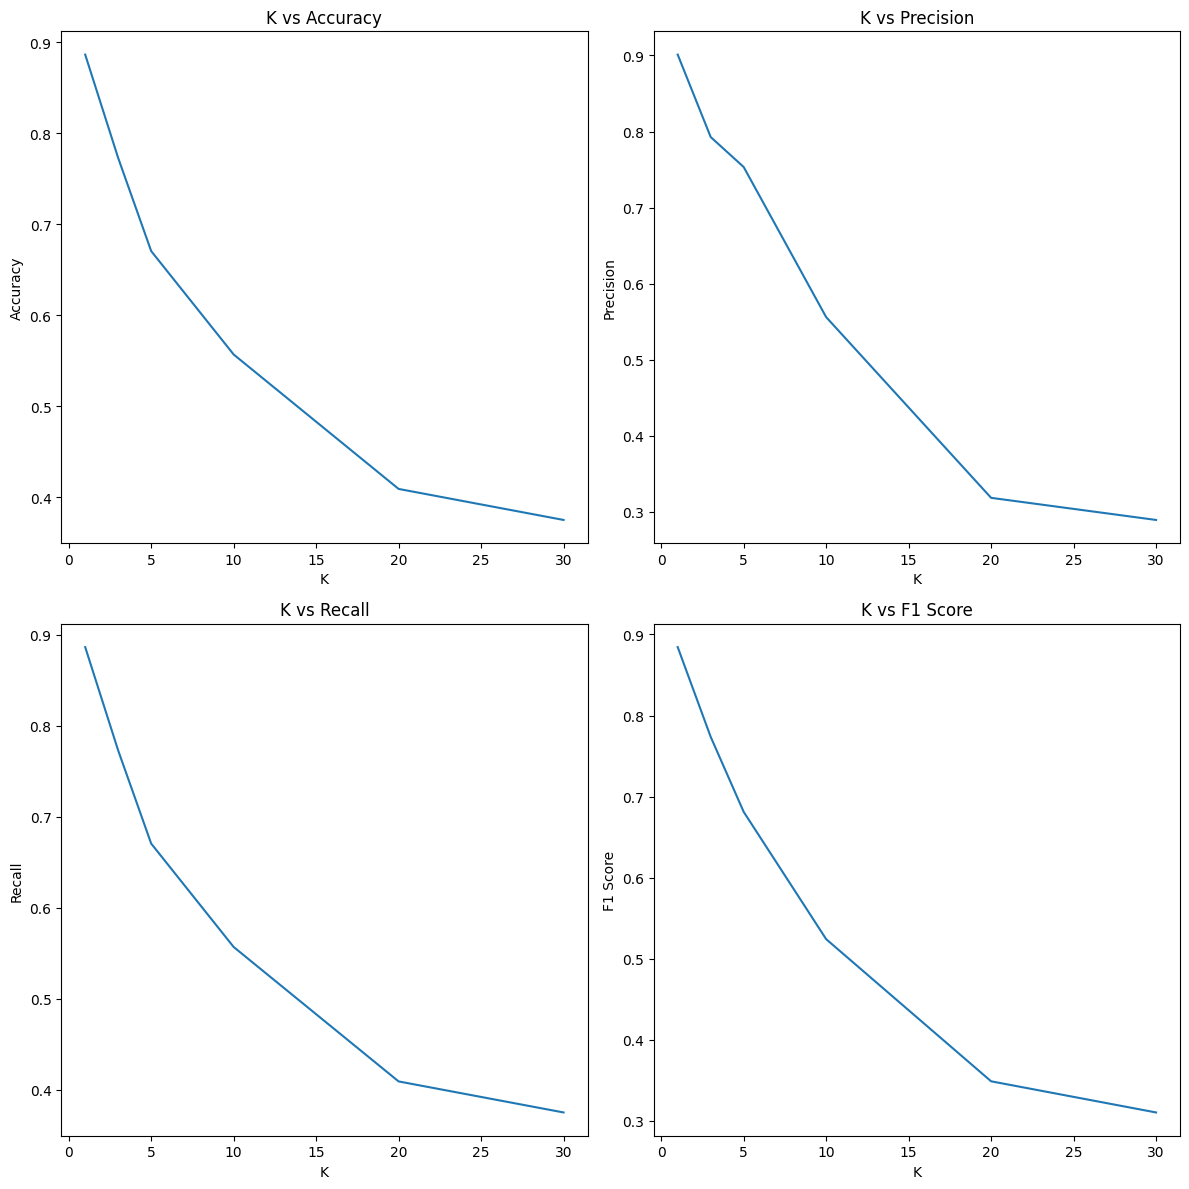

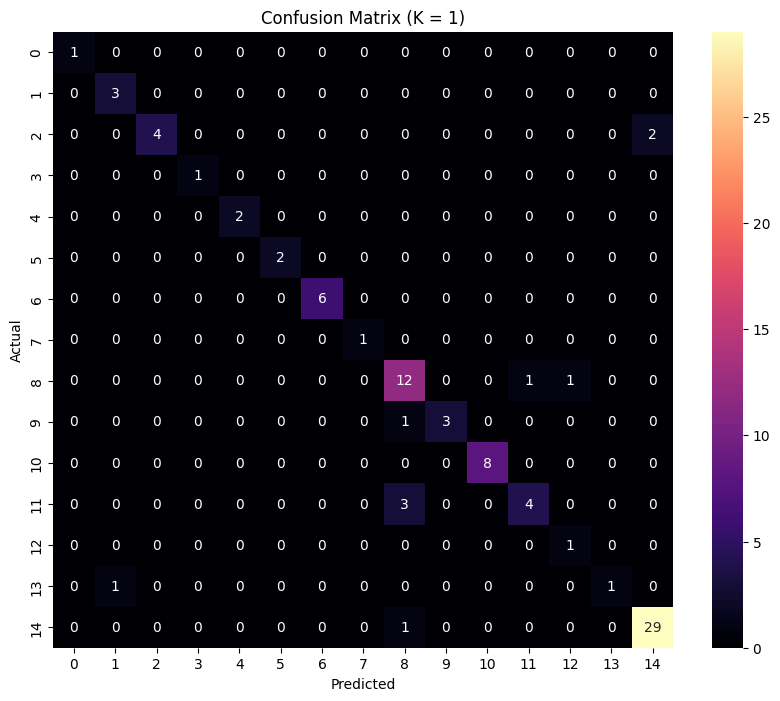

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

# -------- Load dataset -----------
df = pd.read_csv("vibe_dataset_lat_lon_vibe.csv")

# 🔥 FIX: Remove rows with missing or blank values
df = df.replace('', np.nan).dropna()

X = df[["latitude", "longitude"]]
y = df["vibe"]

# convert radians
X_rad = np.radians(X)

# label encode
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y_enc = encoder.fit_transform(y)

# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_rad, y_enc, test_size=0.2, random_state=42
)

# -------- Hyperparameter values to test ----------
neighbors_list = [1, 3, 5, 10, 20, 30]

accuracy_values = []
precision_values = []
recall_values = []
f1_values = []

# -------- Train & evaluate ----------
for k in neighbors_list:
    knn = KNeighborsClassifier(n_neighbors=k, metric='haversine')
    knn.fit(X_train, y_train)
    pred = knn.predict(X_test)

    accuracy_values.append(accuracy_score(y_test, pred))
    precision_values.append(
        precision_score(y_test, pred, average="weighted", zero_division=0)
    )
    recall_values.append(
        recall_score(y_test, pred, average="weighted", zero_division=0)
    )
    f1_values.append(
        f1_score(y_test, pred, average="weighted", zero_division=0)
    )


# -------- Plot graphs -----------
plt.figure(figsize=(12,12))

plt.subplot(2,2,1)
plt.plot(neighbors_list, accuracy_values)
plt.title("K vs Accuracy")
plt.xlabel("K")
plt.ylabel("Accuracy")

plt.subplot(2,2,2)
plt.plot(neighbors_list, precision_values)
plt.title("K vs Precision")
plt.xlabel("K")
plt.ylabel("Precision")

plt.subplot(2,2,3)
plt.plot(neighbors_list, recall_values)
plt.title("K vs Recall")
plt.xlabel("K")
plt.ylabel("Recall")

plt.subplot(2,2,4)
plt.plot(neighbors_list, f1_values)
plt.title("K vs F1 Score")
plt.xlabel("K")
plt.ylabel("F1 Score")

plt.tight_layout()
plt.show()

# -------- Confusion Matrix ----------
best_k = neighbors_list[accuracy_values.index(max(accuracy_values))]
knn_best = KNeighborsClassifier(n_neighbors=best_k, metric='haversine')
knn_best.fit(X_train, y_train)
y_pred_best = knn_best.predict(X_test)

cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, cmap="magma", fmt="d")
plt.title(f"Confusion Matrix (K = {best_k})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
